In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from stop_words import get_stop_words
sns.set()
%matplotlib inline 

# Creacion de un Regresor
Para resolver el problema planteado, es necesario utilizar regresion lineal para obtener los descriptores de la imagen. Entre las multiples librerias disponibles para realizar esta tarea se opto por utilizar keras. Con keras, basta con definir una MLP donde la ultima capa no aplique ningun activador ni un soft-max. Para simplificar el contenido de este notebook, hemos implementado nuestro regresor en una libreria a parte, desde la cual importamos lo siguiente:

In [4]:
from src.regressor import Regressor, r_square, rmse

Using TensorFlow backend.


Es posible ver los metodos definidos dentro al utilizar la funcion python help o accediendo directamente a la carpeta contenedora del codigo que sera adjuntada con la entrega.

Para agilizar el proceso, todos los regresores que se utilizaran en la obtencion de los indicadores seran cargados desde disco. Pero a continuacion mostraremos el procedimiento necesario para entrenar un nuevo modelo, incluyendo la verificacion de overfitting y el guardar el modelo resultante a disco.

### Calculo de los descriptores de texto
El primer paso es obtener los vectores que describen cada una de las 100000 frases contenidas en el set de entrenamiento. Se implementan dos alternativas para este procedimiento:
* CountVectorizer: ....
* TF-IDF: ...

Ambas alternativas deben ser configuradas por medio de una serie de parametros. Varias estos parametros sera priordial al momento de entrenar distintos Regressores.

Nuevamente, todo el codigo relativo a esta implementacion es creada en un codigo python externo a este notebook y debe ser importada de la siguiente manera:

In [10]:
from src.filehandler import DataHandler

En esta seccion, se creara un Regresor utilizando TF-IDF como generador de vectores. La configuracion a utilizar sera:
* ngram-range = (1, 3)
* stop-words = spanish

In [8]:
stop_words = get_stop_words('spanish')
# debemos indicar el directorio que contiene los datos y los sub-directorios que contienen cada dataset
data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
# y obtenemos nuestros vectores
X_train, X_test, y_train, y_test = data.get_data(method="tf-idf", stop_words=stop_words, ngram_range=(1, 3))
print("shapes")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting vectors transforms ...done
shapes
X_train: (100000, 640)
y_train: (100000, 2048)
X_test: (5000, 640)
y_test: (5000, 2048)


Luego creamos un regressor para este tamaño de vectores, con dos capas escondidas, cada una de 200 neuronas. Adicionalmente, se utilizada la configuracionÑ
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True


Adicionalmente, se implementa un Early Stopping con una paciencia de 4 epocas y que monitorea el loss de validacion, de forma que cuando deje de decrecer o empiece a aumentar, detenga el entrenamiento y evite un overfitting. Ademas, se monitorea la metrica de MAE (mean absolute error), RMSE (root mean square error) y R-square.

In [9]:
in_dim = X_train.shape[1]
out_dim = y_train.shape[1]
reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=2, layer_size=200, 
                loss='mean_squared_error', optimizer='adam', metrics=['mae', rmse, r_square])
reg.build()
history = reg.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               128200    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              411648    
Total params: 580,048
Trainable params: 580,048
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s 76us/step - loss: 0.6440 - mean_absolute_error: 0.4863 - rmse: 0.7907 - r_square: 0.1230 - val_loss: 0.5643 - val_mean_absolute_error: 0.4579 - val_rmse: 0.7396 - val_r_square: 0.2334
Epoch 2/100
80000/80000 [==============================] - 5s 68us/step - loss: 0.5444 - mean_absolute_e

Como se observa al ejecutar la celda de arriba, entrenar el modelo entrega informacion sobre las metricas al terminar cada epoca y se detiene cuando el loss deja de bajar. Es posible observar las metricas o evaluar el modelo en otro data-set, ejecutando la siguiente celda:

evaluando test
5000/5000 [==============================] - 0s 45us/step
    EVALUATION RESULTS :  
loss: 0.52
mean_absolute_error: 0.44
rmse: 0.70
r_square: 0.30


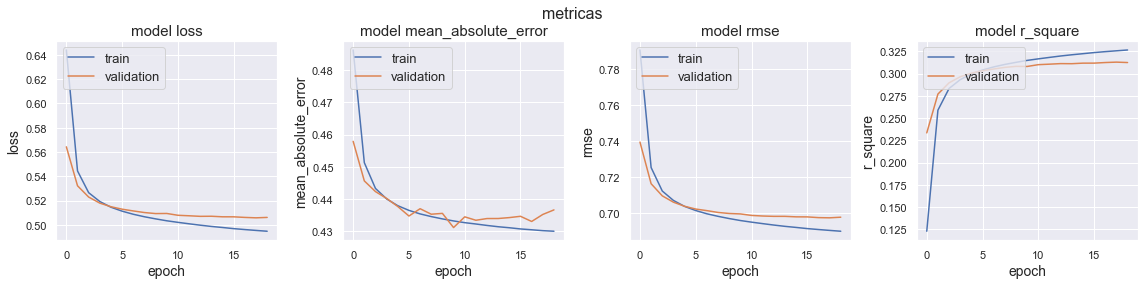

In [10]:
# graficar las metricas
reg.plot_metrics()

# evaluar el modelo
scores = reg.evaluate(X_test, y_test)

Por ultimo, el modelo debe ser guardado si se desea utilizarlo para situaciones posteriores, esto se realiza muy facilmente de la siguiente forma:

saving model to disk ... done!
loading model from disk ... done!
evaluando test
5000/5000 [==============================] - 0s 84us/step
    EVALUATION RESULTS :  
loss: 0.52
mean_absolute_error: 0.44
rmse: 0.70
r_square: 0.30


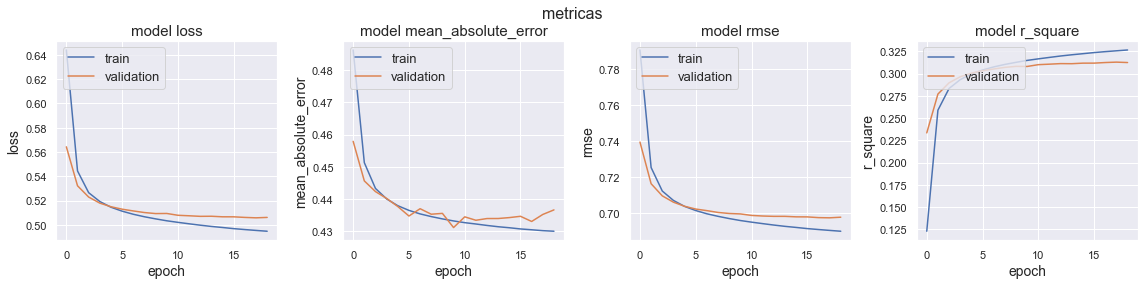

In [12]:
reg.save("test")
# se puede verificar esto al cargar el modelo en una nueva variable
reg2 = Regressor()
reg2.load("test", custom_objects={"rmse": rmse, "r_square": r_square})
# y veamos que evaluar el conjunto de test da los mismos resultados
score2 = reg2.evaluate(X_test, y_test)

# graficar las metricas
metrics = reg2.plot_metrics()

### Casos de estudio
Para este trabajo se opto por fijar una arquitectura para el regresor y estudiar diversas configuraciones en la obtencion de los descriptores de texto. La arquitectura comun para todos los casos de estudio sera la misma que fue utilizada en el ejemplo de arriba, en particular:

* capas internas:
    * fully-connected de 200 neuronas con activador ReLu
    * fully-connected de 200 neuronas con activador ReLu
* capa de salida: fully-connected de 2048 sin activador
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True
* Early Stopping : tolerancia de 0.005, con una paciencia de 4 epochas
* metricas monitoreadas : Mean Absolute Error, Root Mean Square Error, R-Square


Luego, los casos de estudio seran:

* Count-vectorizer con ngram_range = (1,1) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y con stop_words de español
* TF-IDF con ngram_range = (1,1) y sin stop_words
* TF-IDF con ngram_range = (1,4) y sin stop_words
* TF-IDF con ngram_range = (1,4) y con stop_words de español

Los regresores para cada uno de estos modelos se encuentran almacenados en la carpeta /model con nombres descriptivos de cada configuracion, de forma que puedan ser cargados facilmente.

A continuacion se presentan graficos de cada uno de estos regressores para asegurar que ninguno de ellos presente overffiting.

loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!


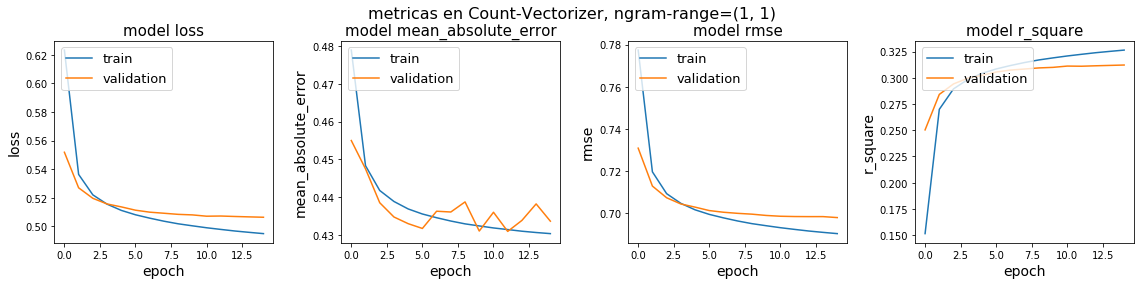

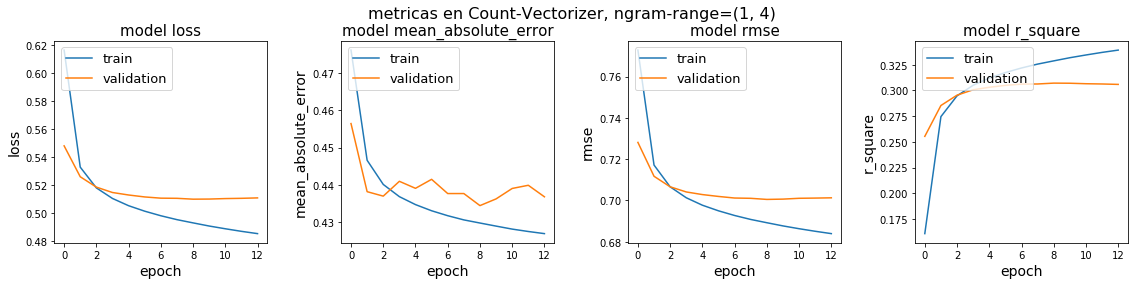

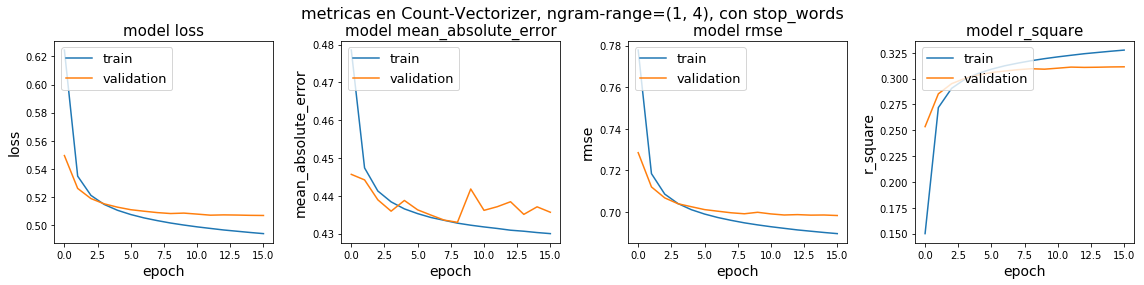

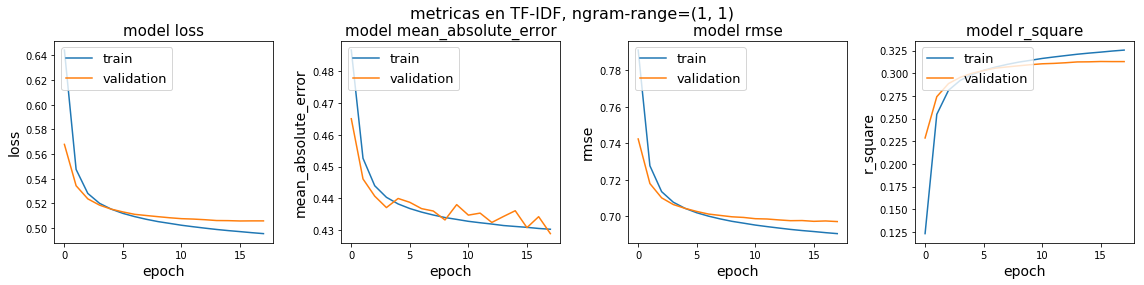

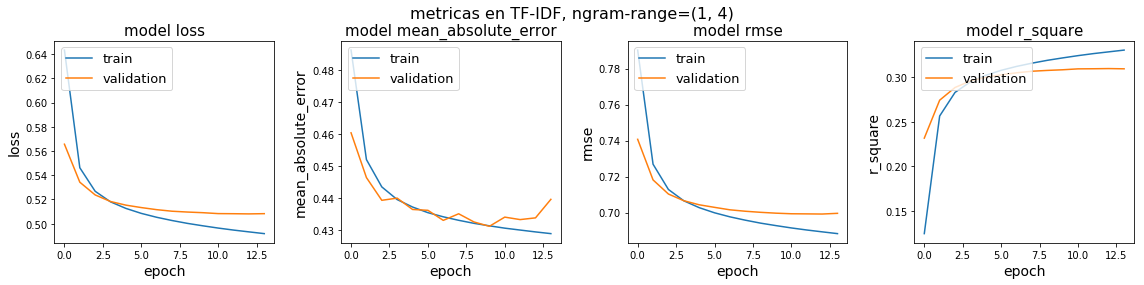

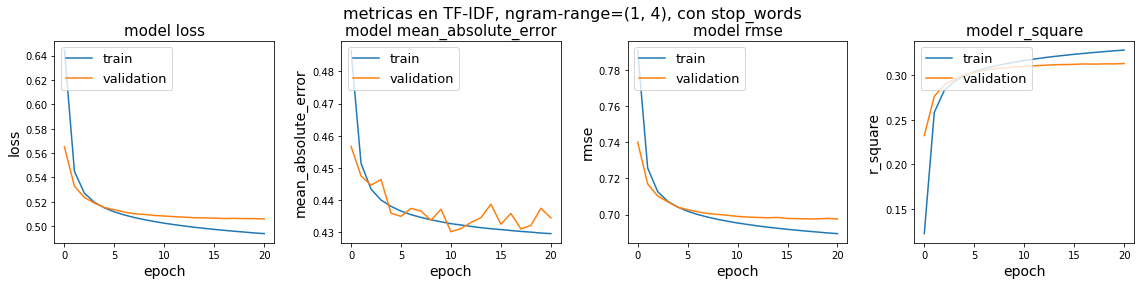

In [5]:
reg1 = Regressor()
reg2 = Regressor()
reg3 = Regressor()
reg4 = Regressor()
reg5 = Regressor()
reg6 = Regressor()
reg1.load("cv_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg1.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 1)")
reg2.load("cv_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg2.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4)")
reg3.load("cv_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg3.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4), con stop_words")
reg4.load("tf_idf_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg4.plot_metrics("metricas en TF-IDF, ngram-range=(1, 1)")
reg5.load("tf_idf_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg5.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4)")
reg6.load("tf_idf_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
metrics = reg6.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4), con stop_words")

Donde se observa que el loss del set de validacion siempre se mantiene cercano al loss de entrenamiento, caracteristica crucial para evitar el overfitting. Se presentan adicionalmente otras metricas utilizadas en regressiones (RMSE, MAE, R2) y todas siempre se mantienen similares para entrenamiento y validacion. Todo esto sugiere claramente que se han entrenado los regresores correctamente.

Un ultimo resultado que podemos obtener es la evaluacion de estas metricas en algun conjunto de test. Esto se muestra a continuacion en una pequeña tabla de pandas.

In [4]:
from collections import defaultdict
stop_words = get_stop_words('spanish')
data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
reg = Regressor()
metrics = {}
methods = ["count-vectorizer"] * 3 + ["tf-idf"] * 3
ngram_ranges = [(1, 1), (1, 4), (1, 4)] * 3
stop_words_list = ([None] * 2 + [stop_words]) * 2
models = ["cv_ngram11_none", "cv_ngram14_none", "cv_ngram14_stop_words",
          "tf_idf_ngram11_none", "tf_idf_ngram14_none", "tf_idf_ngram14_stop_words"]
for method, model, ngram_range, sw in zip(methods, models, ngram_ranges, stop_words_list):
    X_train, X_test, y_train, y_test = data.get_data(method=method, stop_words=sw, ngram_range=ngram_range, verbose=False)
    reg.load(model, custom_objects={"rmse": rmse, "r_square": r_square})
    scores = reg.evaluate(X_test, y_test, verbose=False)
    metrics[model] = scores



W0707 02:32:13.029830  6412 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 02:32:13.040773  6412 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0707 02:32:13.049750  6412 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 02:32:13.075707  6412 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 02:32:13.075707  6412 deprecation_wrapper.py:119] From c:\prog

loading model from disk ... done!
5000/5000 [==============================] - 0s 44us/step
loading model from disk ... done!
5000/5000 [==============================] - 0s 52us/step
loading model from disk ... done!
5000/5000 [==============================] - 0s 51us/step
loading model from disk ... done!
5000/5000 [==============================] - 0s 52us/step
loading model from disk ... done!
5000/5000 [==============================] - 0s 63us/step
loading model from disk ... done!
5000/5000 [==============================] - 0s 59us/step


In [15]:
df = pd.DataFrame.from_dict(metrics, orient="index", columns=["MSE", "MAE", "RMSE", "R2"])
df
# este dataframe puede ser guardado a disco con
df.to_csv("")

,MSE,MAE,RMSE,R2
cv_ngram11_none,0.514832,0.442833,0.704703,0.298794
cv_ngram14_none,0.520425,0.439221,0.708342,0.291282
cv_ngram14_stop_words,0.515872,0.439397,0.705112,0.297643
tf_idf_ngram11_none,0.514989,0.432423,0.704085,0.298931
tf_idf_ngram14_none,0.516810,0.443114,0.706048,0.296064
tf_idf_ngram14_stop_words,0.515313,0.438198,0.704616,0.298323


### Análisis de datos

Para analizar los resultados obtenidos por la regresión vamos a calcular varias métricas más, las que son:
* Silimarity search, busqueda de los más cercanos. Para los 5000 vectores de test se guardan
  las posiciones de los 1000 vectores más cercanos, de 1000 vectores, lo que se traduce en un
  ordenamiento de las predicciones segun distancia entre el descriptor de texto y el de imagen.
* Un vector de posiciones correctas, para cada descriptor de texto se calcula donde está ubicada
  la respuesta correcta dada la matriz obtenida en similarity search, serian 5000 números entre
  el 1 y el 1000. Con esto se muestra un histograma para visualizar mejor la frecuencia de las posiciones.
* Recall@k, que correspode al porcentaje de esos 5000 números que son menores o iguales a K.
  Especificamente se calcula recall@1, recall@5 y recall@10.
* MRR o mean reciprocal rank
* Posición promedio del vector de posiciones correctas.


In [6]:
import src.utils as utils

## Crear descriptores de texto para los test propuestos

Primero cargamos los datos necesarios para calcular los descriptores de texto, para los 6 test
descritos más arriba.

In [11]:
stop_words = get_stop_words('spanish')
data_A = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
data_B = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_B_data")
data_C = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_C_data")
X_test1= data_A.get_data_test(method="count-vectorizer", stop_words=None, ngram_range=(1,1), verbose=False)
X_test2= data_A.get_data_test(method="count-vectorizer", stop_words=None, ngram_range=(1,4), verbose=False)
X_test3= data_A.get_data_test(method="count-vectorizer", stop_words=stop_words, ngram_range=(1,4), verbose=False)
X_test4= data_A.get_data_test(method="tf-idf", stop_words=None, ngram_range=(1,1), verbose=False)
X_test5= data_A.get_data_test(method="tf-idf", stop_words=None, ngram_range=(1,4), verbose=False)
X_test6= data_A.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4), verbose=False)

# Calcular indicadores

Calculamos los vectores resultantes de evaluar los test en las regresiones, y se cargan tambien los descriptores de imagen de largo 1000, para hacer luego el similarity search.

In [12]:
#calculamos los vectores resultantes del predict para cada test
vectores_1 = reg1.predict(X_test1)
vectores_2 = reg2.predict(X_test2)
vectores_3 = reg3.predict(X_test3)
vectores_4 = reg4.predict(X_test4)
vectores_5 = reg5.predict(X_test5)
vectores_6 = reg6.predict(X_test6)
#cargamos los descriptores de imagenes
y_simple_test_A = data_A.load_simple_test("A") #este es el que usaremos a priori
#los test B y C se usaran para hacer una validacion final para ver si hay overfitting
y_simple_test_B = data_B.load_simple_test("B")
y_simple_test_C = data_C.load_simple_test("C")

leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
leyendo ./data/test_B_data/test_B_images_names.txt
leyendo ./data/test_B_data/test_B_images_vectors.bin
1000 vectores de largo 2048
leyendo ./data/test_C_data/test_C_images_names.txt
leyendo ./data/test_C_data/test_C_images_vectors.bin
1000 vectores de largo 2048


In [13]:
#cargar medidor de indicadores para Similarity search, recall at k, MRR y Mean
from src.indicators import Indicators
ind = Indicators()

In [14]:
rank_1 = ind.similarity_search(y_simple_test_A, vectores_1)
datos_1 = ind.get_formated_data()
rank_2 = ind.similarity_search(y_simple_test_A, vectores_2)
datos_2 = ind.get_formated_data()
rank_3 = ind.similarity_search(y_simple_test_A, vectores_3)
datos_3 = ind.get_formated_data()
rank_4 = ind.similarity_search(y_simple_test_A, vectores_4)
datos_4 = ind.get_formated_data()
rank_5 = ind.similarity_search(y_simple_test_A, vectores_5)
datos_5 = ind.get_formated_data()
rank_6 = ind.similarity_search(y_simple_test_A, vectores_6)
datos_6 = ind.get_formated_data()

initializing KDTRee ... done!
 :::: computing distances with L2 metric :::: 
no number of jobs where specified
There are 4 CPUs on this machine
launching 4 jobs: .... DONE!
waiting 4 jobs: .... DONE!
grouping the data ... DONE! [shape: (5000, 1000)]
(5000, 1000)
 :::: done! (elapse time: 201.65 secs.) :::: 
getting sorted ranking ...done! (elapse time: 0.06 secs.)
done!
initializing KDTRee ... done!
 :::: computing distances with L2 metric :::: 
no number of jobs where specified
There are 4 CPUs on this machine
launching 4 jobs: .... DONE!
waiting 4 jobs: .... DONE!
grouping the data ... DONE! [shape: (5000, 1000)]
(5000, 1000)
 :::: done! (elapse time: 210.17 secs.) :::: 
getting sorted ranking ...done! (elapse time: 0.06 secs.)
done!
initializing KDTRee ... done!
 :::: computing distances with L2 metric :::: 
no number of jobs where specified
There are 4 CPUs on this machine
launching 4 jobs: .... DONE!
waiting 4 jobs: .... DONE!
grouping the data ... DONE! [shape: (5000, 1000)]
(500

# Mostrar datos obtenidos

Luego de calculados los vectores de posiciones, se grafican sus respectivos histogramas y una tabla con las metricas mencionadas anteriormente.

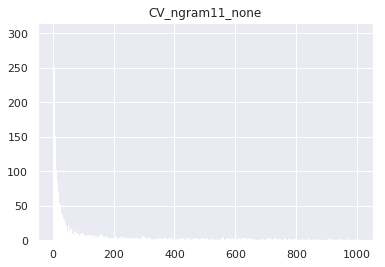

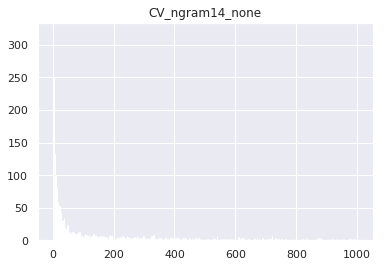

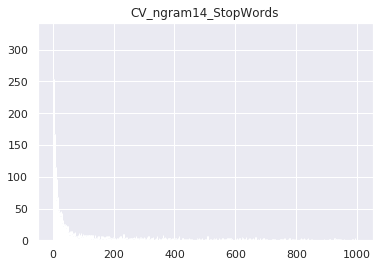

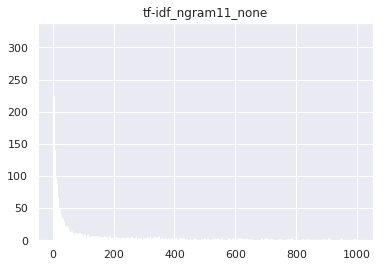

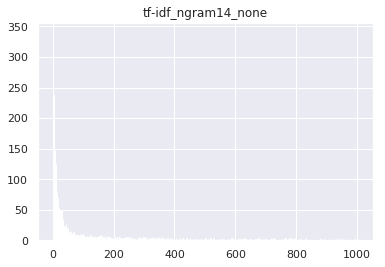

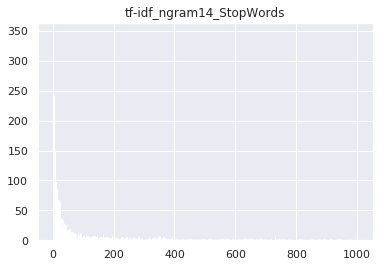

In [15]:
labels = ['recall@1','recall@5','recall@10','MRR','Mean']
index = ['CV_ngram11_none', 'CV_ngram14_none','CV_ngram14_StopWords',
         'tf-idf_ngram11_none', 'tf-idf_ngram14_none','tf-idf_ngram14_StopWords']
datos = [datos_1, datos_2, datos_3,datos_4, datos_5, datos_6]
tabla = utils.get_table(datos, index, labels)
utils.print_histo(rank_1,index[0])
utils.print_histo(rank_2,index[1])
utils.print_histo(rank_3,index[2])
utils.print_histo(rank_4,index[3])
utils.print_histo(rank_5,index[4])
utils.print_histo(rank_6,index[5])

In [16]:
tabla

,recall@1,recall@5,recall@10,MRR,Mean
CV_ngram11_none,0.0600,0.2192,0.3416,0.147287,123.0536
CV_ngram14_none,0.0636,0.2266,0.3402,0.150460,119.7922
CV_ngram14_StopWords,0.0652,0.2228,0.3458,0.152514,119.9920
tf-idf_ngram11_none,0.0644,0.2208,0.3376,0.149207,122.3536
tf-idf_ngram14_none,0.0678,0.2246,0.3464,0.153862,118.4948
tf-idf_ngram14_StopWords,0.0692,0.2248,0.3450,0.155181,119.1726


Se observa que todos los experimentos tienen metricas muy parecidas, pero el que tiene las mejores métricas en general es el TF-IDF con ngram_range = (1,4) y con stop_words de español. Entonces probaremos con los test B y C para ver si tienen metricas similares tambien.

In [17]:
X_test6_B= data_B.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4))
X_test6_C= data_C.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4))
vectores_6_B = reg6.predict(X_test6_B)
vectores_6_C = reg6.predict(X_test6_C)
rank_6_B = ind.similarity_search(y_simple_test_B, vectores_6_B)
datos_6_B = ind.get_formated_data()
rank_6_C = ind.similarity_search(y_simple_test_C, vectores_6_C)
datos_6_C = ind.get_formated_data()

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_B_data//test_B_images_names.txt
leyendo ./data/test_B_data//test_B_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting test vectors transforms ...text descriptor shape: (5000, 640)
done
leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_C_data//test_C_images_names.txt
leyendo ./data/test_C_data//test_C_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting test vectors transforms ...text descriptor shape: (5000, 640)
done
initializing KDTRee ... done!
 :::: computing distances with L2 metric :::: 
no number of jobs where specified
There are 4 CPUs on this machine
launching 4 jobs: .... DONE!
waiting 4 jobs: .... DONE!
grouping t

In [18]:
index = ['Test_A', 'Test_B','Test_C']
datos = [datos_6, datos_6_B, datos_6_C]
tabla = utils.get_table(datos, index, labels)
tabla

,recall@1,recall@5,recall@10,MRR,Mean
Test_A,0.0692,0.2248,0.3450,0.155181,119.1726
Test_B,0.0732,0.2348,0.3498,0.157697,120.7294
Test_C,0.0668,0.2364,0.3634,0.158091,108.4202


# Conclusiones finales